### This a tutorial of color recommendation for json files.
Process:
- Step1: Extract the color palettes of Image-SVG-Text elements from json file, show multiple palettes and design image
- Step2: Get the recommended colors for a specified color in a specified palette
** If you want to check the recolored results with the recommended colors, please check the video of our prototype system.

In [2]:
# !python3 -m pip install tensorflow-cpu

In [10]:
import json
import io
import os
import numpy as np
import cv2
import time
from operator import itemgetter, attrgetter
from PIL import Image
import matplotlib.pyplot as plt
from ipywidgets import Image as ipyImage
from ipycanvas import Canvas
from base64 import b64encode, b64decode
import pandas as pd
from collections import defaultdict  # For word frequency
import math
import random
import ast

import sys
sys.path.append('../src')

from multipalette.utils.color_convertor import lab_to_rgb, rgb_to_lab, range0to255, imageRGBA2LAB
from multipalette.preprocess.color_extractor import get_colors
from multipalette.colorbert.input_data_generator import DataGenerator
from multipalette.colorbert.model_config import Config

# reset the sample url to check different samples
sample_url = '../data/model_test_input/crello_samples/json_sample_2.json'


## Extract the color palettes of Image-SVG-Text elements
- Convert image data RGB to CIELab
- Use Kmeans clustering in sklearn (kmeans in faiss can be faster, while the result is a little different)
- Check the extracted colors by converting Lab to RGB

In [11]:
# reshape image as [w*h, 3] to concate multiple images
def reshape_image(pil_image):
    image = np.array(pil_image)
    # remove the 4th channel of image
    if len(image.shape) > 2 and image.shape[2] == 4:
        #convert the image from RGBA2RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR) # Alpha channel may should be concerned in future work
    image = image.reshape((image.shape[0] * image.shape[1], 3))
    return image

# draw palette without color rate
def draw_palette(colors):
    palette = np.zeros((50, 300, 3), dtype = "uint8")
    startX = 0
    for c in range(len(colors)):
        endX = startX + (1 / len(colors) * 300)
        cv2.rectangle(palette, (int(startX), 0), (int(endX), 50), colors[c], -1)
        startX = endX
    # draw border line for easy check in light gray #D3D3D3 
    cv2.rectangle(palette, (0, 0), (300, 50), (211, 211, 211), 2)
    plt.imshow(palette)
    plt.axis('off')
    plt.show()

../src/multipalette/preprocess/color_extractor.py:20: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  # cluster the pixel intensities


Image palette:
RGB data: [[52, 109, 120], [56, 93, 96], [178, 147, 108], [240, 238, 234], [59, 57, 51]]
Lab data: [[109, 113, 116], [94, 116, 122], [160, 134, 153], [240, 128, 130], [61, 128, 132]]


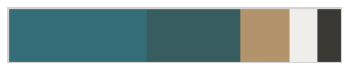

SVG palette:
RGB data: [[36, 30, 32], [187, 147, 101], [24, 66, 64]]
Lab data: [[31, 131, 128], [162, 137, 158], [64, 113, 125]]


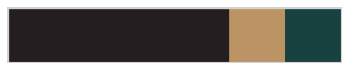

Text palette:
RGB data: [[203, 193, 128], [255, 255, 255]]
Lab data: [[198, 122, 162], [255, 128, 128]]


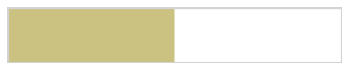

Canvas(height=788, sync_image_data=True, width=940)

In [12]:
# load json file and show multiple palettes of Image-SVG-Text elements and the whole design image

with open(sample_url) as json_file:
    example = json.load(json_file)

    canvas_width = example['canvas_width']
    canvas_height = example['canvas_height']
    # draw all elements in canvas
    canvas = Canvas(width=canvas_width, height=canvas_height, sync_image_data=True)

    # initial image_list, svg_list, text_list
    image_list = []
    svg_list = []
    text_list = []
    text_size = []

    for i in range(len(example['types'])):
        layer = example[f'element_{i}']
        # if example['type'][i] != b'textElement':
        x = layer['left']*canvas_width
        y = layer['top']*canvas_height
        width = layer['width']*canvas_width
        height = layer['height']*canvas_height
        color_rgb = layer['color']
        color_hex = '#%02x%02x%02x' % (color_rgb[0], color_rgb[1], color_rgb[2])

        # reconstruct canvas to check
        image = ipyImage.from_file(io.BytesIO(b64decode(layer['image_bytes'])))
        canvas.draw_image(image, x, y, width, height)    

        if example['types'][i] == 'imageElement' or example['types'][i] == 'maskElement':
            image_pil = Image.open(io.BytesIO(b64decode(layer['image_bytes'])))
            image_list.append(reshape_image(imageRGBA2LAB(image_pil)))

        if example['types'][i] == 'svgElement' or example['types'][i] == 'coloredBackground':
            svg_pil = Image.open(io.BytesIO(b64decode(layer['image_bytes'])))
            svg_list.append(reshape_image(imageRGBA2LAB(svg_pil)))

        if example['types'][i] == 'textElement':
            canvas.font = f'{height}px sans-serif'
            canvas.stroke_style = color_hex
            canvas.fill_style = color_hex
            canvas.fill_text('TEXT', x, y+height)
            canvas.stroke_rect(x, y, width, height)
            if [color_rgb[0], color_rgb[1], color_rgb[2]] not in text_list:
                text_list.append([color_rgb[0], color_rgb[1], color_rgb[2]])
                text_size.append(width * height)

    for i in range(len(image_list)):
        if i == 0:
            image_np = image_list[i]
        else:
            image_np = np.concatenate((image_np, image_list[i]), axis=0)

    for i in range(len(svg_list)):
        if i == 0:
            svg_np = svg_list[i]
        else:
            svg_np = np.concatenate((svg_np, svg_list[i]), axis=0)

    # sort text color list by text area size
    text_list = [x for _, x in sorted(zip(text_size, text_list), reverse=True)]
    if len(text_list) > 5:
        text_np = np.array(text_list)
        (text_colors, text_colors_lab, text_color_rates, text_palette) = get_colors(text_np, 5)
    else:
        text_colors = text_list
        text_colors_lab = [rgb_to_lab(rgb) for rgb in text_list]


    if len(image_list) > 0:
        # image_np = reduce_color_bins(image_np)
        (image_colors, image_colors_lab, image_color_rates, image_palette) = get_colors(image_np, 5)
    if len(svg_list) > 0:
        # svg_np = reduce_color_bins(svg_np)
        (svg_colors, svg_colors_lab, svg_color_rates, svg_palette) = get_colors(svg_np, 5)
    # if len(text_list) > 0:
    #     print(text_colors)

    print('Image palette:')
    print(f'RGB data: {image_colors}')
    print(f'Lab data: {image_colors_lab}')
    # print(f'Color rates: {image_color_rates}')
    plt.imshow(image_palette)
    plt.axis('off')
    plt.show()

    print('SVG palette:')
    print(f'RGB data: {svg_colors}')
    print(f'Lab data: {svg_colors_lab}')
    # print(f'Color rates: {svg_color_rates}')
    plt.imshow(svg_palette)
    plt.axis('off')
    plt.show()

    print('Text palette:')
    print(f'RGB data: {text_colors}')
    print(f'Lab data: {text_colors_lab}')
    draw_palette(text_colors)

canvas

## Get the recommended colors for a specified color in a specified palette
### Prepare the color dataset for BERT input
- Color sequance of multiple palettes: image colors (max 5), svg colors (max 5), text colors (max 5)
- Color corpus: assign color in a b×b×b histogram/bin (b=16 in this work)

### Load trained model

In [13]:
import tensorflow as tf

re_model = tf.keras.models.load_model(f"../data/trained_models/bert_lab_bins_16_0.1_0.3_nop_2")

2022-09-27 14:07:35.633820: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Set input palettes and denote the masked position manually by setting maskColors

In [14]:
# input rgb
input_palettes = {
    'image': image_colors,
    'svg': svg_colors,
    'text': text_colors,
}

# 1 denotes mask
maskColors = {
    'image': '[0,0,0,0,0]',
    'svg': '[0,1,0]',
    'text': '[0,0]',
}
volumns = ['image', 'svg', 'text']

### Predict the masked color and show top10 results

Original palettes: 


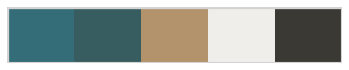

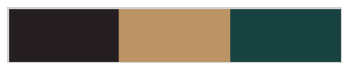

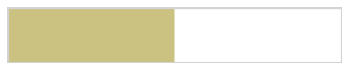

Mask position: 1 denotes mask
{'image': '[0,0,0,0,0]', 'svg': '[0,1,0]', 'text': '[0,0]'}
Recommended results: 


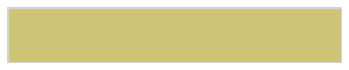

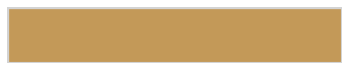

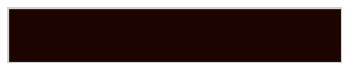

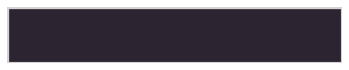

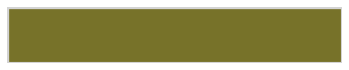

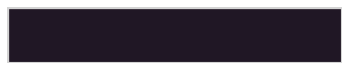

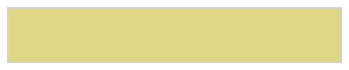

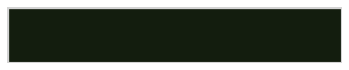

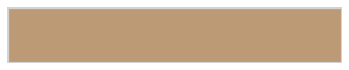

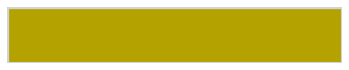

In [ ]:
# save the input_palettes to a temp file for prediction

print('Original palettes: ')
pred_file_path = 'Data_color_pred/color_corpus_pred.txt'

PROJECT_PATH = Config['project_path']
bin_range = Config['bin_range']

with open(os.path.join(PROJECT_PATH, pred_file_path), 'w') as f:
    line = '"'
    for volumn in volumns:
        draw_palette(input_palettes[volumn])
        for c in input_palettes[volumn]:
            lab = rgb_to_lab(c)
            lab_bins = f'{math.floor(lab[0]/bin_range)}_{math.floor(lab[1]/bin_range)}_{math.floor(lab[2]/bin_range)}'
            line += f'{lab_bins} '
        line += '; '
    f.write(f'{line[:len(line) - 3]}"\n')

print('Mask position: 1 denotes mask')
print(maskColors)
max_palette_length = Config['max_palette_length']
mask_positions = []
position = 0

for v in range(len(volumns)):
    pi = 0
    for m in ast.literal_eval(maskColors[volumns[v]]):
        if m == 1:
            mask_positions.append(position+pi)
        pi +=1
    position += max_palette_length[v] + 1  # add 1 position of SEP

Config_pred = Config.copy()
Config_pred['batch_size'] = 1
Config_pred['mask_position'] = mask_positions   # mask specified colors
Config_pred['corpus_file_path'] = os.path.join(PROJECT_PATH, pred_file_path)

sample_id = 0

dataset = DataGenerator(Config_pred)
batch_x,  batch_mlm_mask, batch_mcc_mask, origin_x, batch_segment, batch_padding_mask = dataset[sample_id]
# print(f'original sequence: {dataset.corpus.token_id_to_word_list(list(origin_x[0]))}')
# print(f'masked sequence: {dataset.corpus.token_id_to_word_list(list(batch_x[0]))}')

mlm_predict, output_emb = re_model((batch_x, batch_mlm_mask, batch_segment), training=False)

N = 10

# print(f'original id: {dataset.corpus.token_id_to_word_list([origin_x[0][mask_positions[0]]])}')
# print(f'predicted ids: {dataset.corpus.token_id_to_word_list(list(np.argsort(mlm_predict[0][mask_positions[0]])[::-1][:N]))}')

print('Recommended results: ')

batch_mlm_mask = tf.cast(batch_mlm_mask, dtype=tf.int32)
index = tf.where(batch_mlm_mask == 1)
# x_predict = tf.math.argmax(mlm_predict, axis=-1) # top1
x_predict = tf.argsort(mlm_predict, axis=-1, direction='DESCENDING') # topn    
x_predict = tf.gather_nd(x_predict, index)
x_real = tf.gather_nd(origin_x, index)
x_predict = x_predict.numpy()
x_real = x_real.numpy()

for p in range(len(x_predict)):
    pred = []
    for i in range(N):
        pred.append(x_predict[p][i])
    # check GT in predicted colors
    if pred:
        for pr in pred:
            c = dataset.corpus.token_id_to_word_list([pr])
            lab = c[0].split('_')
            bin_bias = 0.5
            rgb = range0to255(lab_to_rgb([(float(lab[0])+bin_bias)*bin_range, (float(lab[1])+bin_bias)*bin_range, (float(lab[2])+bin_bias)*bin_range]))
            # print(rgb)
            draw_palette([rgb])
